# 加载数据集

In [87]:
from datasets import load_dataset

train_dataset = load_dataset("noanabeshima/TinyStoriesV2", split='train[:10%]', cache_dir='E:\8. data\hugggingface')
val_dataset = load_dataset("noanabeshima/TinyStoriesV2", split='validation', cache_dir='E:\8. data\hugggingface')


In [2]:
print(train_dataset)    # 用 trian_dataset['text'][i] 获取第 i 条数据
print(val_dataset)      # 用 val_dataset['text'][i] 获取第 i 条数据

Dataset({
    features: ['text'],
    num_rows: 271769
})
Dataset({
    features: ['text'],
    num_rows: 27629
})


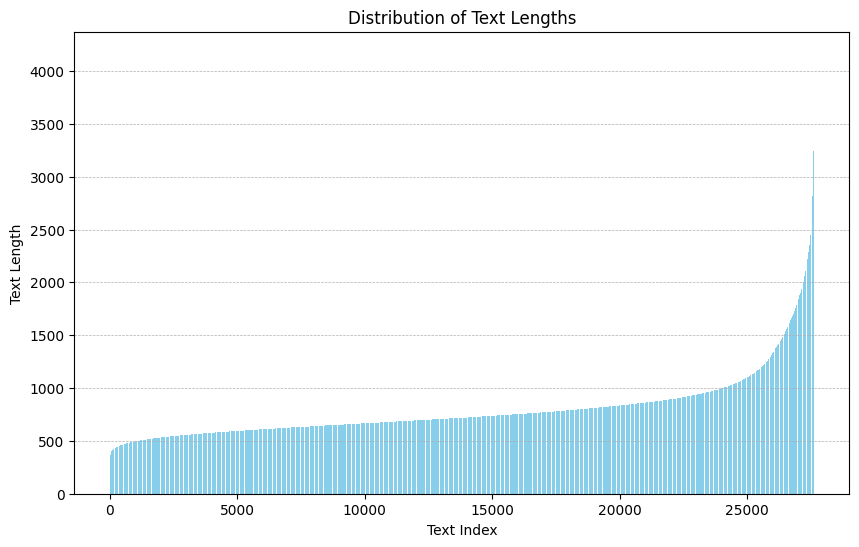

In [47]:
# 检查 val_dataset 文本数据的平均长度，排序绘制柱状图
import matplotlib.pyplot as plt

text_lengths = [len(text) for text in val_dataset['text']]
text_lengths = sorted(text_lengths)

plt.figure(figsize=(10, 6))
plt.bar(range(len(text_lengths)), text_lengths, color='skyblue')
plt.xlabel('Text Index')
plt.ylabel('Text Length')
plt.title('Distribution of Text Lengths')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

# 数据预处理

In [36]:
# 数据预处理
from transformers import AutoTokenizer, LlamaTokenizerFast

# 使用 LLama2 的词表 （32k），LLama3 的太大了（128k）
tokenizer = AutoTokenizer.from_pretrained('NousResearch/Llama-2-7b-hf')
tokenizer

d:\Programmer\Anaconda3\envs\transformers39\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


LlamaTokenizerFast(name_or_path='NousResearch/Llama-2-7b-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [63]:
from typing import Dict, List

def sample_preprocess(examples: Dict[str, List], tokenizer) -> Dict[str, List]:
    ''' 输入输出都是 Dict[str, List] 格式，允许 batch 形式处理 '''
    # 得到 token 序列最大长度，根据原始数据可视化图，选择 2048 基本不会浪费数据
    max_token = 2048

    # 进行 tokenize，跳过所有 special_tokens，在 LLaMA 中就是不会在句首加上 bos_token <s>
    encoded_texts = tokenizer(examples['text'], add_special_tokens=False)   
    
    # 保留后 <=max_token-1 token，再加上 eos_token，总长度 <= max_token
    # 从保留尾部而非头部序列是重要的，因为数据中必须包含 eos_token，这样模型才能学会何时结束输出
    new_input_ids_list, new_attn_mask_list = [], []
    for input_ids in encoded_texts['input_ids']:
        temp = input_ids[-max_token+1:] + [tokenizer.eos_token_id]
        new_input_ids_list.append(temp)
        new_attn_mask_list.append([1] * len(temp))  # 所有 token 都可以关注，attention 全 1

    return {
        "input_ids": new_input_ids_list,
        "attention_mask": new_attn_mask_list
    }

In [68]:
train_dataset = train_dataset.shuffle()         # 训练集打乱一下
train_dataset = train_dataset.map(
    lambda example: sample_preprocess(example, tokenizer),
    batched=True,
    batch_size=10000,
    remove_columns=train_dataset.column_names,  # 移除原始数据字段
    desc='Running tokenizer on train_set: '
)

val_dataset = val_dataset.map(
    lambda example: sample_preprocess(example, tokenizer),
    batched=True,
    batch_size=10000,
    remove_columns=val_dataset.column_names,    # 移除原始数据字段
    desc='Running tokenizer on val_set: '
)

print(train_dataset)
print(val_dataset)

Running tokenizer on train_set:   0%|          | 0/271769 [00:00<?, ? examples/s]

Running tokenizer on val_set:   0%|          | 0/27629 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 271769
})
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 27629
})


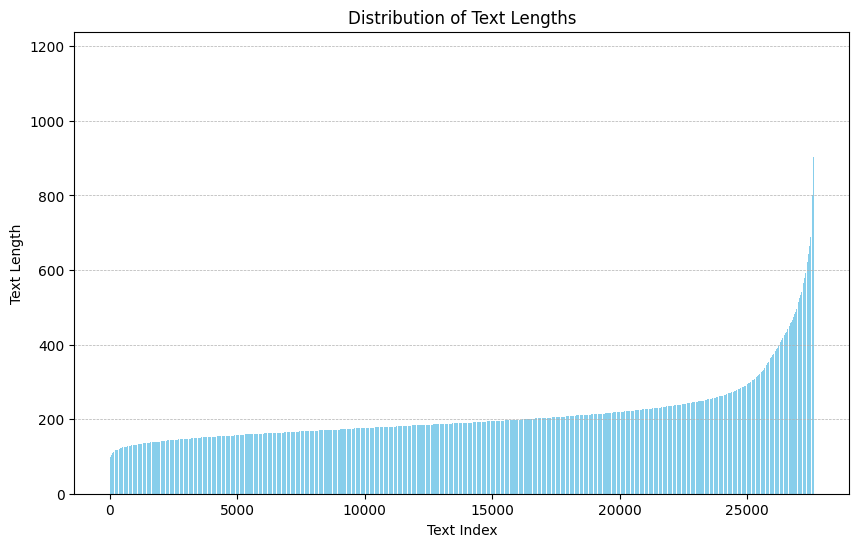

In [71]:
# 检查 val_dataset 文本数据的平均长度，排序绘制柱状图，val_dataset 所有数据长度不超过 2048，几乎没有浪费数据
import matplotlib.pyplot as plt

text_lengths = [len(text) for text in val_dataset['input_ids']]
text_lengths = sorted(text_lengths)

plt.figure(figsize=(10, 6))
plt.bar(range(len(text_lengths)), text_lengths, color='skyblue')
plt.xlabel('Text Index')
plt.ylabel('Text Length')
plt.title('Distribution of Text Lengths')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [74]:
from transformers import DataCollatorForLanguageModeling

# DataCollator 类似 torch Dataloader 中的 collect_fn，将 Dataset 中的原始数据组合成 batch，得到可以直接输入模型的形式
# 为了组成 batch，DataCollator 通常会应用某些处理（比如padding到相同长度），有些还会在数据批次上应用随机数据增强（比如随机masking）
# DataCollatorForLanguageModeling 在设置 mlm=False 时，直接适用于自回归 FLM 训练目标
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [77]:
data = ['南京', '南京市', '南京市长江']
raw_tokens = [tokenizer(text, add_special_tokens=False) for text in data]

print(f'tokenizer.pad_token_id: {tokenizer.pad_token_id}\n')
print(data_collator(raw_tokens))

'''
tokenizer.pad_token_id: 0

{'input_ids': tensor([[    0,     0,     0, 29871, 30601, 30675],   # 注意到有 left zero padding
                      [    0,     0, 29871, 30601, 30675, 30461],
                      [29871, 30601, 30675, 30461, 31143, 30775]]), 
    'attention_mask': tensor([[0, 0, 0, 1, 1, 1],                   # 注意到 zero padding 部分不进行 attention
                              [0, 0, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1, 1]]), 
    'labels': tensor([[ -100,  -100,  -100, 29871, 30601, 30675],   # 注意到 zero padding 部分 label 设为 -100, 代表被忽略
                      [ -100,  -100, 29871, 30601, 30675, 30461],
                      [29871, 30601, 30675, 30461, 31143, 30775]])}
'''


tokenizer.pad_token_id: 0

{'input_ids': tensor([[    0,     0,     0, 29871, 30601, 30675],
        [    0,     0, 29871, 30601, 30675, 30461],
        [29871, 30601, 30675, 30461, 31143, 30775]]), 'attention_mask': tensor([[0, 0, 0, 1, 1, 1],
        [0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]]), 'labels': tensor([[ -100,  -100,  -100, 29871, 30601, 30675],
        [ -100,  -100, 29871, 30601, 30675, 30461],
        [29871, 30601, 30675, 30461, 31143, 30775]])}


# 创建模型

In [34]:
# 模型配置
from transformers import AutoConfig

# 根据 TinyStory 论文设置部分超参数
hidden_size = 256                                               
num_hidden_layers = 4
intermediate_size = (int(hidden_size * 8/3 / 128) + 1) * 128    # 中间层取 8/3 倍，按 128 向上取整。用 8/3 而非 2 倍是因为 SwiGLU 包含三个参数矩阵   
num_attention_heads = 16                                        # 注意力头共 16 个
num_key_value_heads = 8                                         # 注意力头分 8 组，每组内 2 个头共用 key 和 value，即 GQA 机制

# 改动 llama 中的以上超参数默认值，其余保持不变
config = AutoConfig.for_model(
    model_type="llama",
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    intermediate_size=intermediate_size,    
    num_attention_heads=num_attention_heads,                 
    num_key_value_heads=num_key_value_heads                   
)

config

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 768,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 16,
  "num_hidden_layers": 4,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.40.0",
  "use_cache": true,
  "vocab_size": 32000
}

In [35]:
import torch
from transformers import AutoModelForCausalLM

# 从 config 加载模型，不使用预训练 ckpt，序列生成类模型要选择 CausalLM
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModelForCausalLM.from_config(                    
    config,
    torch_dtype=torch.float32   # 全精度训练
).to(device)                    # 迁移到 device 上

model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 256)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=256, out_features=256, bias=False)
          (k_proj): Linear(in_features=256, out_features=128, bias=False)
          (v_proj): Linear(in_features=256, out_features=128, bias=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=256, out_features=768, bias=False)
          (up_proj): Linear(in_features=256, out_features=768, bias=False)
          (down_proj): Linear(in_features=768, out_features=256, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
      (1): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q

In [6]:
# 打印模型的每一层及其参数大小
def print_model_parameters(model):
    print("Layer Name & Parameters")
    print("----------------------------")
    total_params = 0
    for name, parameter in model.named_parameters():
        param_size = parameter.size()
        param_count = torch.prod(torch.tensor(param_size)).item()
        total_params += param_count
        print(f"{name:50} | Size: {str(param_size):30} | Count: {str(param_count):20}")
    print("----------------------------")
    print(f"Total Parameters: {total_params} ({total_params / 1000000:.1f} M)")

print_model_parameters(model)

Layer Name & Parameters
----------------------------
model.embed_tokens.weight                          | Size: torch.Size([32000, 256])       | Count: 8192000             
model.layers.0.self_attn.q_proj.weight             | Size: torch.Size([256, 256])         | Count: 65536               
model.layers.0.self_attn.k_proj.weight             | Size: torch.Size([128, 256])         | Count: 32768               
model.layers.0.self_attn.v_proj.weight             | Size: torch.Size([128, 256])         | Count: 32768               
model.layers.0.self_attn.o_proj.weight             | Size: torch.Size([256, 256])         | Count: 65536               
model.layers.0.mlp.gate_proj.weight                | Size: torch.Size([768, 256])         | Count: 196608              
model.layers.0.mlp.up_proj.weight                  | Size: torch.Size([768, 256])         | Count: 196608              
model.layers.0.mlp.down_proj.weight                | Size: torch.Size([256, 768])         | Count: 196608  

In [33]:
# LlamaPreTrainedModel._init_weight 是 llama 使用的默认初始化方法
# 这里给出两种其他的初始化方法
import numpy as np

def small_init_weights(model):
    # SAMLLINIT是Xavier初始化的变体，这里还结合了GPT2的初始化方法
    # 参考：https://zhuanlan.zhihu.com/p/676464982
    for name, param in model.named_parameters():
        if 'embed_tokens.weight' in name:
            param.data.normal_(mean=0.0, std=model.config.initializer_range)
        elif 'self_attn' in name:
            param.data.normal_(mean=0.0, std=np.sqrt(2/(model.config.hidden_size + model.config.intermediate_size)))
        elif 'down_proj' in name:
            param.data.normal_(mean=0.0, std=np.sqrt(2/(model.config.hidden_size + model.config.intermediate_size)) / np.sqrt(config.num_hidden_layers))
        elif 'bias' in name:
            torch.nn.init.constant_(param, 0)

def kaiming_initialization(model):
    # 凯明初始化，更适合类 ReLU 激活
    # 参考：https://zhuanlan.zhihu.com/p/305055975
    for name, param in model.named_parameters():
        if 'weight' in name and param.dim() > 1:
            torch.nn.init.kaiming_uniform_(param, mode='fan_in', nonlinearity='leaky_relu')
        elif 'bias' in name:
            torch.nn.init.constant_(param, 0)

#kaiming_initialization(model)
#small_init_weights(model)

# 推理方法

In [14]:
def inference(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    input_text: str = "Once upon a time, ",
    max_new_tokens: int = 16
):
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=40,
        top_p=0.95,
        temperature=0.8
    )
    generated_text = tokenizer.decode(
        outputs[0],
        skip_special_tokens=True
    )
    #print(outputs)
    return generated_text

In [15]:
# 训练之前，随机初始化的模型只能生成乱码
generated_text = inference(model, tokenizer)
print(generated_text)

Once upon a time,  ChampionsdemásBR Champions able Works华食食 sharedжธservmacht shared veg


# 启动训练

In [79]:
import os
basepath = os.path.abspath(os.path.join(os.path.dirname('__file__')))
os.environ['WANDB_DISABLED'] = 'true'   # 关闭 wandb

'c:\\Users\\wwxc9\\Desktop\\git\\LLM_task_practice\\01_TinyStory'

In [84]:
from transformers import TrainingArguments

# 创建训练配置
training_args = TrainingArguments(
    output_dir=f'{basepath}/output',            # 输出路径，包括模型检查点、中间文件等
    save_total_limit=2,                         # output_dir 内留存的检查点最大数目
    overwrite_output_dir=True,                  # 是否覆写 output_dir
    num_train_epochs=2,                         # 训练轮数，2 ~ 3 即可
    per_device_train_batch_size=5,             # 训练 batch_size（一个 epoch 存在 ceil(data_num/bsz) 个 batch）
    per_device_eval_batch_size=10,             # 验证 batch_size
    gradient_accumulation_steps=1,              # 梯度累计步大小，显存不变时扩展等效 batch_size，小模型没必要。参考 https://blog.csdn.net/wxc971231/article/details/139177793
    do_train=True,                              # 是否做训练
    do_eval=True,                               # 是否做评估
    evaluation_strategy='steps',                # 使用 steps 策略时，eval_steps 才有效（这是默认设置）
    eval_steps=1000,                            # 评估步骤间隔
    save_strategy='steps',                      # 使用 steps 策略时，save_steps 才有效（这是默认设置）
    save_steps=1000,                            # 检查点保存步骤间隔
    logging_steps=50,                           # 打印步骤间隔
    learning_rate=1e-4,                         # 学习率大小
    lr_scheduler_type='cosine',                 # 学习率调度策略，LLM 训练一般都用余弦
    bf16=torch.cuda.is_bf16_supported(),        # 尝试配置 bf16
    fp16=not torch.cuda.is_bf16_supported(),    # bf16 不行就上 fp16
    report_to=None,                             # 日志输出目标，不想用 wandb 可以设置为 None
    seed=3407                                   # 随机种子
)

In [85]:
from transformers import Trainer

# 创建 Trainer
trainer = Trainer(
    model=model,                    # 模型实例
    args=training_args,             # 训练参数
    train_dataset=train_dataset,    # 训练集
    eval_dataset=val_dataset,       # 验证集（评估集）
    data_collator=data_collator,    # data collator
)

In [86]:
# 开始训练
trainer.train()

  0%|          | 0/108708 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 386.00 MiB (GPU 0; 8.00 GiB total capacity; 6.56 GiB already allocated; 85.06 MiB free; 6.60 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF